In [2]:
from os.path import join, isfile, isdir
from os import listdir
from multiprocessing import Pool
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from shutil import copy
from PIL import Image
import requests
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
year = "2020"
state = "MA"

In [ ]:
data = np.load("MA_2020.npz")

In [ ]:
feats = data["feats"]
locs = data["locs"]

In [ ]:
# dataclip = np.load("MA_2020_clip.npz")
# feats_clip = dataclip["feats"]
# locs_clip = dataclip["locs"]

In [ ]:
from transformers import AutoTokenizer, CLIPTextModelWithProjection
import torch

ModuleNotFoundError: No module named 'transformers'

In [ ]:
device = "cpu"

In [ ]:
textmodel = (
    CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch16")
    .eval()
    .to(device)
)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [ ]:
texts = [
    "A place for hiking",
    "A lake, river or a water body",
    "City",
    "Roads or Freeways",
    "Tennis courts",
    "Beach",
    "Forests",
    "Marshland",
    "Farmland",
    "wind farm",
    "solar farm",
]
with torch.no_grad():
    textsenc = tokenizer(texts, padding=True, return_tensors="pt").to(
        device
    )  # tokenize
    class_embeddings = F.normalize(
        textmodel(**textsenc).text_embeds, dim=-1
    )  # embed with text encoder

In [ ]:
classprob = feats @ class_embeddings.cpu().numpy().T

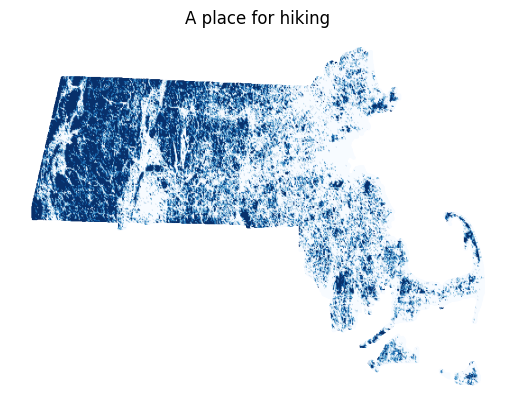

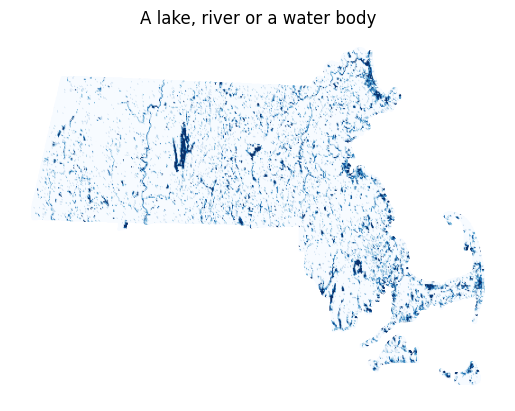

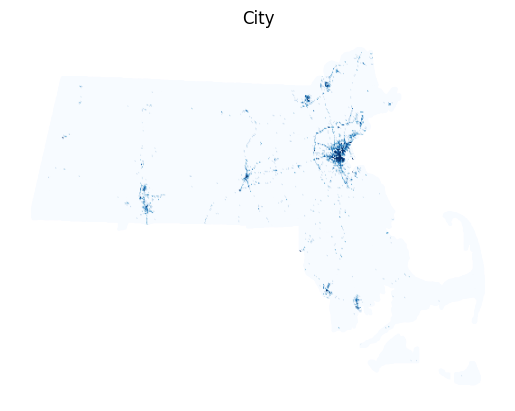

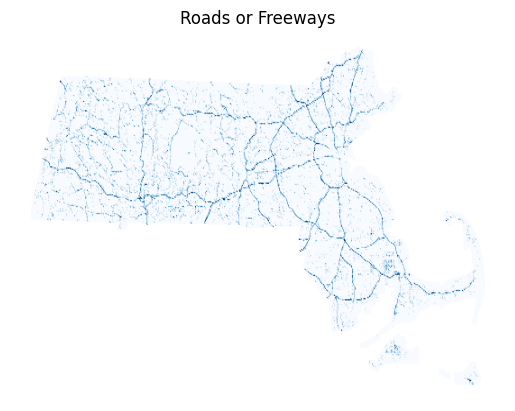

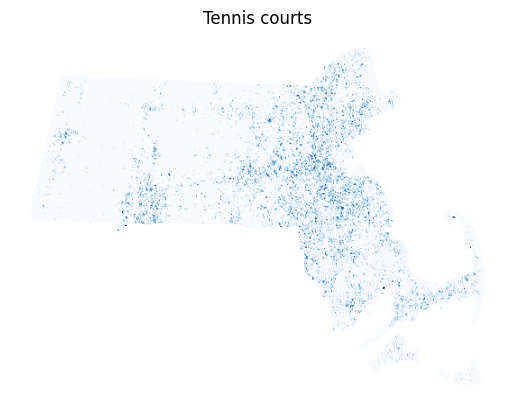

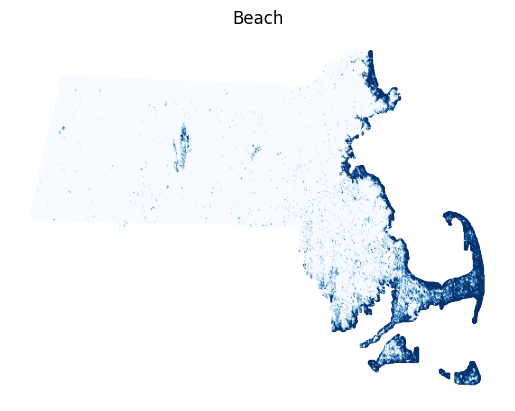

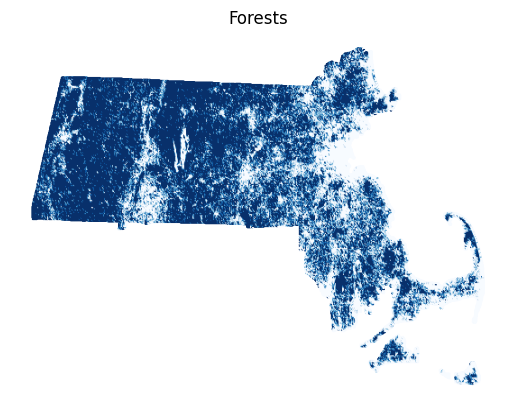

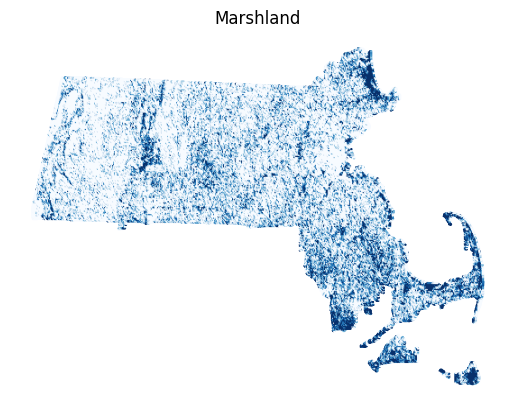

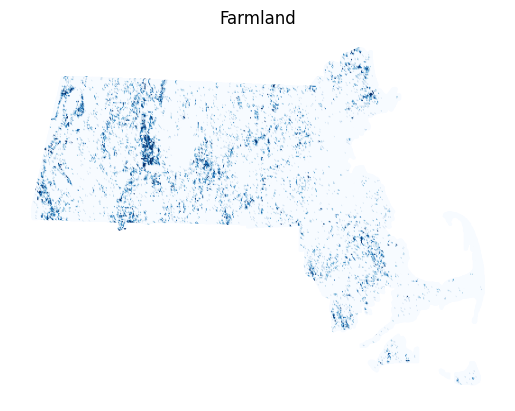

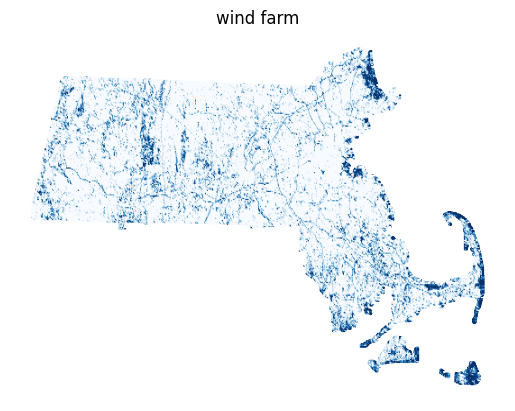

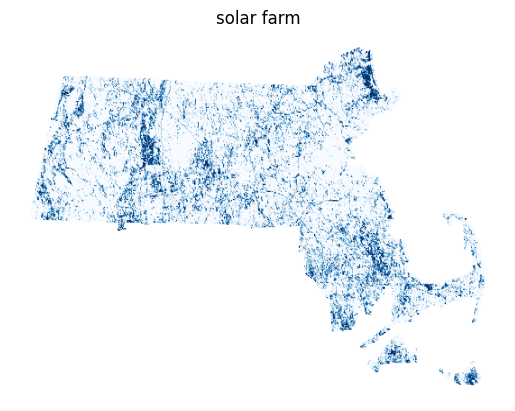

In [ ]:
for index in range(len(texts)):
    plt.title(texts[index])
    if texts[index] == "Farmland":
        thresh = 0.1
    else:
        thresh = 0.05

    plt.hexbin(
        locs[:, 0],
        locs[:, 1],
        C=classprob[:, index] > thresh,
        gridsize=500,
        cmap="Blues",
    )
    plt.axis("Off")
    plt.show()

# Retrieval results


This requires access to the image directory.


In [ ]:
data_dir = "/local/vondrick/utkarsh/datasets/MA/2020/"

In [ ]:
dirs = sorted(listdir(data_dir))

In [ ]:
def get_key(fname):
    return tuple([int(tmp) for tmp in fname.split(".")[0].split("/")[-1].split("_")])


files = []
for dir in dirs:
    files.append(
        [join(data_dir, dir, tmp) for tmp in sorted(listdir(join(data_dir, dir)))]
    )
files = [tmp for tmp2 in files for tmp in tmp2]
files = {get_key(tmp): tmp for tmp in files}

In [ ]:
print(len(files))

580488


In [ ]:
def get_locs(text, clip=False):
    with torch.no_grad():
        textsenc = tokenizer([text], padding=True, return_tensors="pt").to(
            device
        )  # tokenize
        class_embeddings = F.normalize(
            textmodel(**textsenc).text_embeds, dim=-1
        )  # embed with text encoder
    if clip:
        classprob = feats_clip @ class_embeddings.cpu().numpy().T
        best = locs_clip[np.argsort(classprob[:, -1])[::-1][:10]]
    else:
        classprob = feats @ class_embeddings.cpu().numpy().T
        best = locs[np.argsort(classprob[:, -1])[::-1][:10]]
    return best

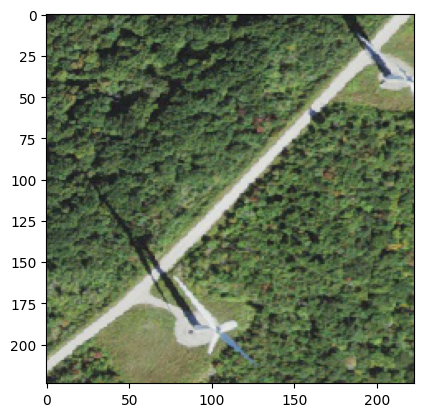

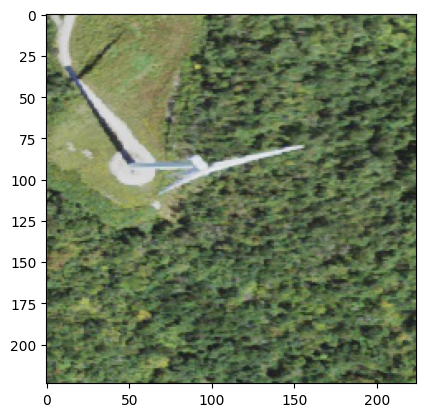

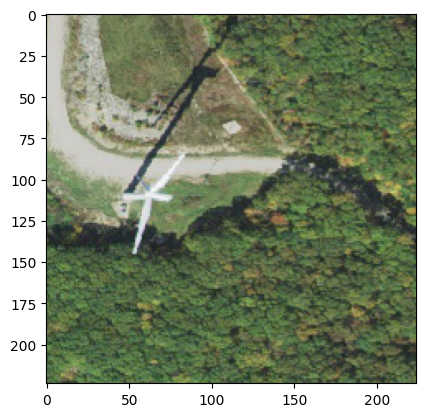

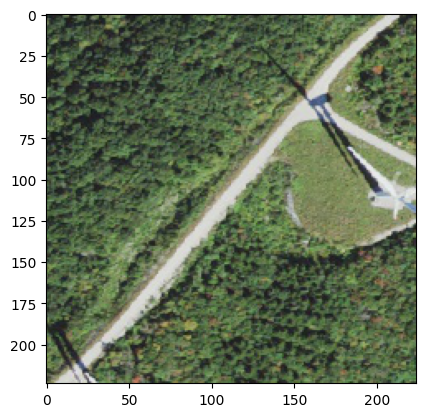

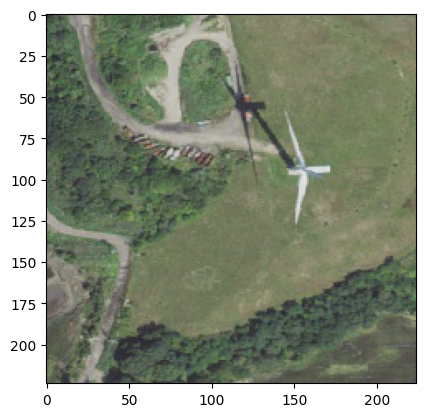

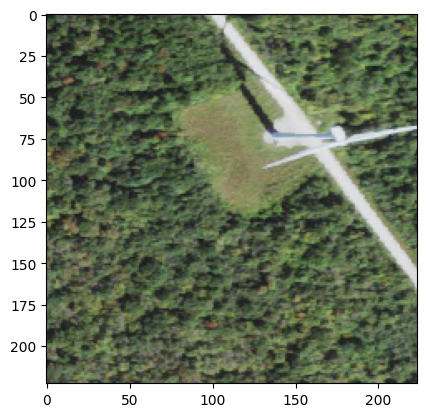

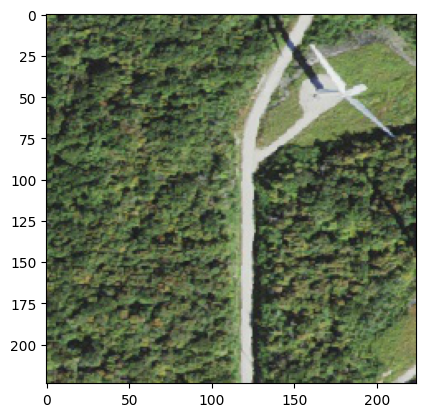

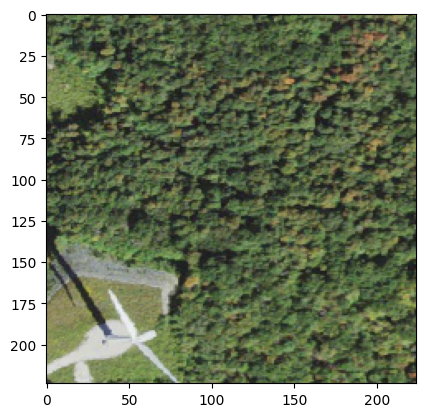

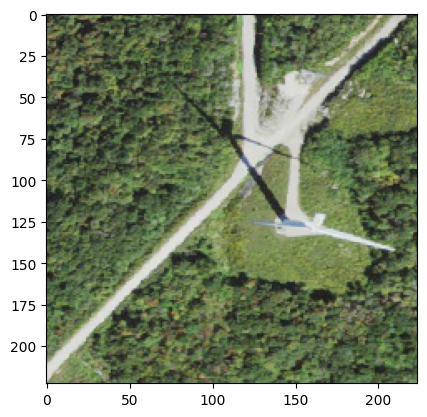

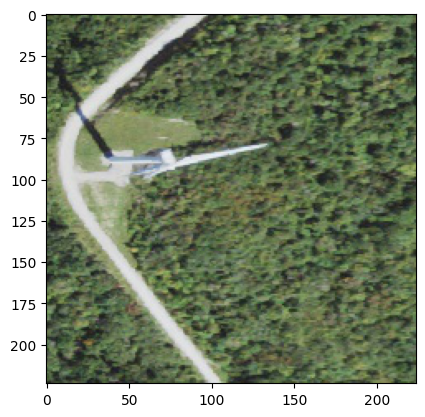

In [ ]:
# pos = get_locs('a photo of an airplane')
query = "a photo of a wind farm"
pos = get_locs(query, clip=False)

# query = 'an aerial image of airplane'
# pos = get_locs(query, clip=True)

for po in pos:
    fname = files[(int(np.round(po[0] * 100000)), int(np.round((po[1]) * 100000)))]
    plt.imshow(np.array(Image.open(fname)))
    plt.show()

In [ ]:
for po in pos:
    fname = files[(int(np.round(po[0] * 100000)), int(np.round((po[1]) * 100000)))]
    copy(fname, "_".join(query.split(" ")) + "_" + fname.split("/")[-1])